In [1]:
# %matplotlib widget
%matplotlib inline

# Projekt: Erkenung von Malaria infizierten Zellen

### Ziel: Ein Methode in Machine Learning entwicklen, um automatisch mikroskopische Bilder zu klassifizieren und vorherzusagen ob die Zelle mit Malaria infiziert ist oder nicht.

Ziel Variable: Parasitized oder Uninfected

### Importieren der wichtigen Libraries

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib widget
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
import cv2 as cv
import glob as gb  # Batch opening
from PIL import Image, ImageEnhance
import PIL
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree, metrics
import imageio

print('Pillow Version: ', Image.__version__)

Pillow Version:  8.2.0


### Variablen

In [3]:
coding = {
    "Parasitized": 1,
    "Uninfected": 0,
}

# Scaling
image_width = 60
image_height = 60

# color_channel = 'gray'
# color_channel = 'red'
color_channel = 'green'
# color_channel = 'blue'

# filepath_root = "./data/cell_images_mini"  # 20 *2 Images
# filepath_root = "./data/cell_images_midi"  # 500 * 2 Images
filepath_root = "./data/cell_images_venti"  # 4000 * 2  Images
# filepath_root = "./data/cell_images"  #   13780 * 2  Images

filepath_part_healthy = 'Uninfected'
filepath_part_infected = 'Parasitized'

images = []
image_paths = []
image_dimensions = []
file_sizes = []
y = []
y_filenames_infected = []
y_filenames_healthy = []
number_of_datapoints = 0
classification_model_stats = []

#### Daten Exploration und Vorverarbeitung

In [4]:
def import_images():
    append_data(filepath_root, filepath_part_healthy, color_channel)
    append_data(filepath_root, filepath_part_infected, color_channel)


def get_file_size(file_path):
    result = 0
    if os.path.isfile(file_path):
        file_info = os.stat(file_path)
        result = file_info.st_size
    return result


def append_data(filepath_root, auxillary_path, color_mode):
    global number_of_datapoints
    print('Color Mode is: :', color_mode)
    path = filepath_root + '/' + auxillary_path + '/' + '*.png'
    print(path)
    for filename in gb.glob(path):
        # print(filename)
        y_filenames_healthy.append(filename)
        with Image.open(filename) as im:
            # Provide the target width and height of the image
            # print(im.size)
            image_dimensions.append(im.size)
            image_raw = im.convert('RGB')
            # RESIZE IMAGE
            scaled_image = scaling_image(image_raw)
            # Increase contrast
            contrast_image = increasing_contrast(scaled_image, 1.9)
            # Select color channel or gray
            im_resized_gray = selecting_color_channel(scaled_image, color_channel)

            # Create numpy array from image
            image_array = np.array(im_resized_gray) / 255.

            images.append(image_array)
            image_paths.append(filename)
            # build y
            if auxillary_path == filepath_part_infected:
                y.append(1)
            else:
                y.append(0)
            # Count the number of used files
            number_of_datapoints = number_of_datapoints + 1
            # collect the file sizes in list
            file_sizes.append(get_file_size(filename))


def display_sample_images(images, number_of, healthy):
    plt.figure(figsize=(20, 8))
    plt.set_cmap('gray')
    my_title = ''
    start = 0
    if healthy:
        start = 0
        my_title = 'Healthy scaled cell in ' + color_channel + 'ch '
    else:
        # Infected begin in second half of data
        start = int(len(images) / 2)
        my_title = 'Inf scaled cell in ' + color_channel + 'ch '
    end = start + number_of
    for i in range(start, end):
        plt.subplot(1, number_of, (i - start + 1))
        image = images[i]
        plt.title(my_title + str(image.shape))
        plt.imshow(image)
        plt.tight_layout()
    plt.show()


def display_sample_images_raw(image_paths, number_of, healthy):
    plt.figure(figsize=(20, 8))
    # plt.set_cmap('gray')
    my_title = ''
    start = 0
    if healthy:
        start = 0
        my_title = 'Healthy cell in color'
    else:
        start = int(len(images) / 2)
        my_title = 'Infected cell in color'
    end = start + number_of
    for i in range(start, end):
        plt.subplot(1, number_of, (i - start + 1))
        image = Image.open(image_paths[i])
        image = image.convert('RGB')
        plt.title(my_title)
        # plt.title(str(image.shape))
        plt.imshow(image)
        plt.tight_layout()
    plt.show()


def scaling_image(image_input):
    (width, height) = (image_width, image_height)
    im_resized = image_input.resize((width, height))
    return im_resized


def increasing_contrast(image_input, factor):
    # Increase contrast
    enhancer = ImageEnhance.Contrast(image_input)
    im_increased_contrast = enhancer.enhance(factor)
    return im_increased_contrast


def selecting_color_channel(image_input, color_mode):
    # Select color channel or gray
    if color_mode == 'gray':
        image_input.convert('RGB')
        image_gray = image_input.convert("L")
    elif color_mode == 'red':
        image_input = image_input.convert('RGB')
        image_gray = image_input.getchannel('R')
    elif color_mode == 'green':
        image_input = image_input.convert('RGB')
        image_gray = image_input.getchannel('G')
    elif color_mode == 'blue':
        image_input = image_input.convert('RGB')
        image_gray = image_input.getchannel('B')
    return image_gray


def display_image_preprocessing(image_paths, healthy):
    my_title = ''
    start = 0
    if healthy:
        start = 0
        my_title = 'Image Preprocessing Stages Healthy'
    else:
        start = int(len(images) / 2)
        my_title = 'Image Preprocessing Stages Infected'
    ##############################
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(40, 10))
    fig.suptitle(my_title, fontsize=16)

    image_raw = Image.open(image_paths[start])
    image_raw = image_raw.convert('RGB')
    scaled_image = scaling_image(image_raw)
    contrast_image = increasing_contrast(scaled_image, 1.9)
    simplified_image = selecting_color_channel(scaled_image, color_channel)

    axes[0].imshow(image_raw)  # cmap='gray'
    axes[0].title.set_text('Original cell, infected')
    axes[1].imshow(scaled_image)
    axes[1].title.set_text('scaled image')
    axes[2].imshow(contrast_image)
    axes[2].title.set_text('contrast image')
    axes[3].imshow(simplified_image)
    axes[3].title.set_text(color_channel + ' image')
    fig.tight_layout()
    plt.show()

In [5]:
# Data Loading and  Preprocessing
import_images()

# 1. Datenexploration
print('Number of datapoints (images): ', number_of_datapoints)
image_dimensions_np = np.array(image_dimensions)
print('image_dimensions as list [0:40]')
print(image_dimensions[0:40])

print('Mean value of image height:')
print(image_dimensions_np[0].mean())
print('Mean value of image width:')
print(image_dimensions_np[1].mean())
print('Maximal value of image height:')
print(np.amax(image_dimensions_np[0]))
print('Maximal value of image width:')
print(np.amax(image_dimensions_np[1]))
print('Minimal value of image height:')
print(np.amin(image_dimensions_np[0]))
print('Minimal value of image width:')
print(np.amin(image_dimensions_np[1]))
print('file sizes [0:40] in bytes')
print(file_sizes[0:40])
file_sizes_np = np.array(file_sizes)
print('Mean value of image file sizes in bytes:')
print(file_sizes_np.mean())
print('Maximal value of image file sizes in bytes:')
print(np.amax(file_sizes_np))
print('Minimal value of image file sizes in bytes:')
print(np.amin(file_sizes_np))

Color Mode is: : green
./data/cell_images_venti/Uninfected/*.png
Color Mode is: : green
./data/cell_images_venti/Parasitized/*.png
Number of datapoints (images):  8000
image_dimensions as list [0:40]
[(148, 133), (175, 127), (145, 169), (139, 136), (133, 136), (199, 136), (163, 148), (181, 214), (130, 148), (169, 127), (142, 121), (166, 145), (139, 130), (133, 139), (136, 121), (136, 124), (166, 166), (127, 148), (124, 130), (136, 142), (133, 112), (151, 151), (166, 106), (139, 133), (142, 133), (133, 136), (133, 133), (139, 145), (127, 127), (130, 127), (151, 127), (151, 115), (139, 124), (130, 124), (133, 133), (157, 118), (136, 133), (148, 142), (139, 121), (142, 139)]
Mean value of image height:
140.5
Mean value of image width:
151.0
Maximal value of image height:
148
Maximal value of image width:
175
Minimal value of image height:
133
Minimal value of image width:
127
file sizes [0:40] in bytes
[16515, 17588, 20233, 13801, 16231, 20224, 18534, 23335, 16786, 15351, 15987, 14995, 15

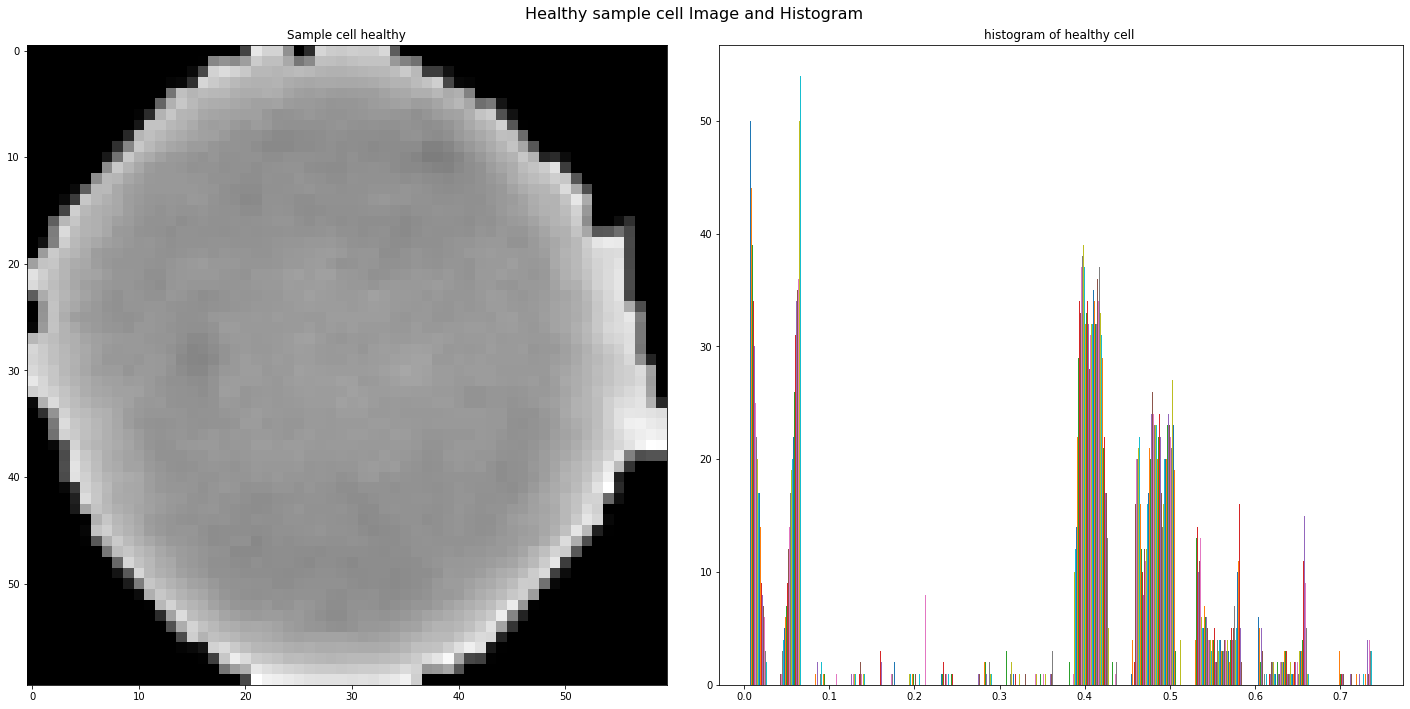

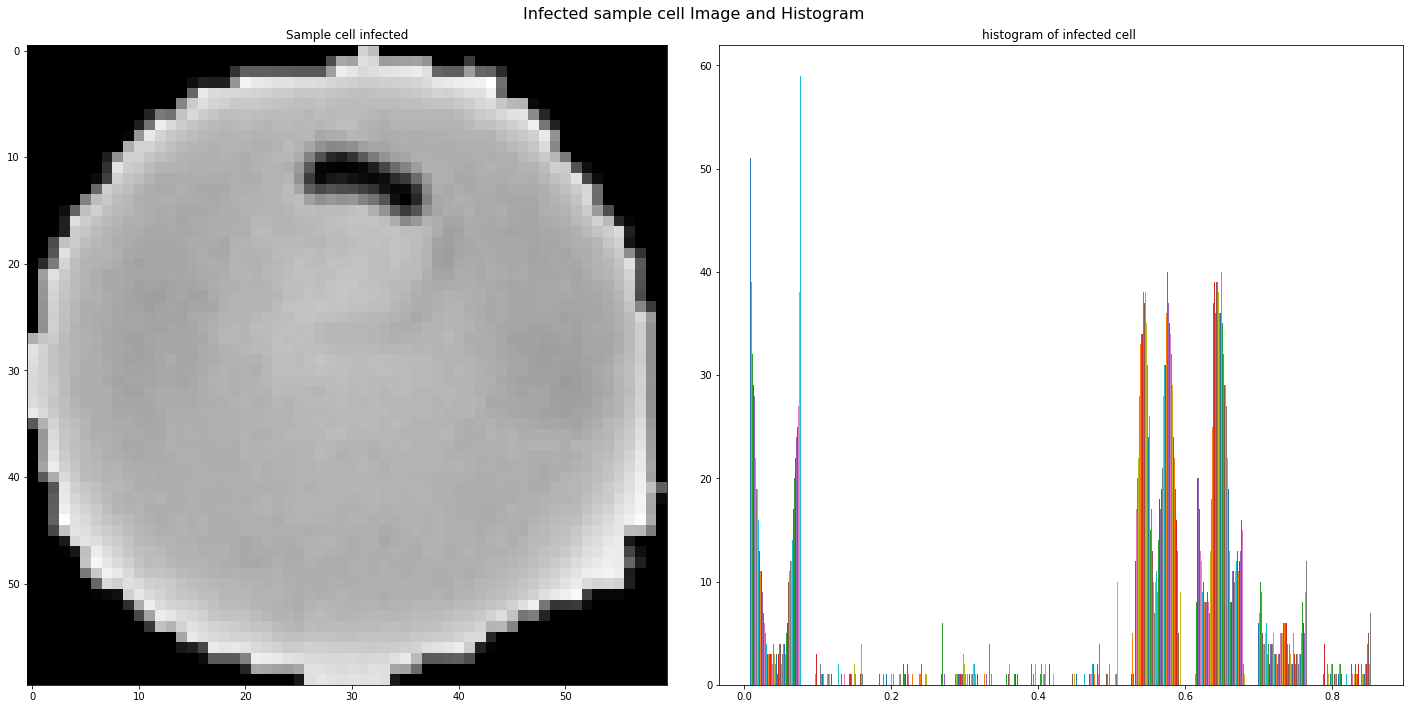

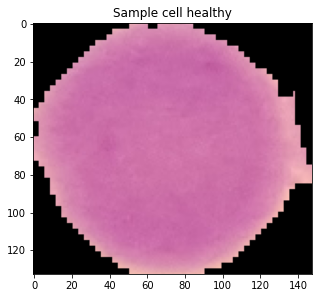

Type of the image : Portable Network Graphics .png 
Shape of the image : (133, 148, 3)
Image Height 133
Image Width 148
Dimension of Image 3
Image pixel * 3 color channels  59052
Maximum RGB value in this image 252
Minimum RGB value in this image 0


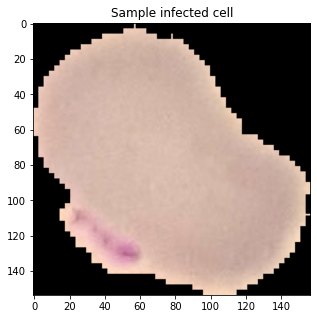

Type of the image : Portable Network Graphics .png 
Shape of the image : (154, 157, 3)
Image Height 154
Image Width 157
Dimension of Image 3
Image pixel size * 3 color channels 72534
Maximum RGB value in this image 255
Minimum RGB value in this image 0


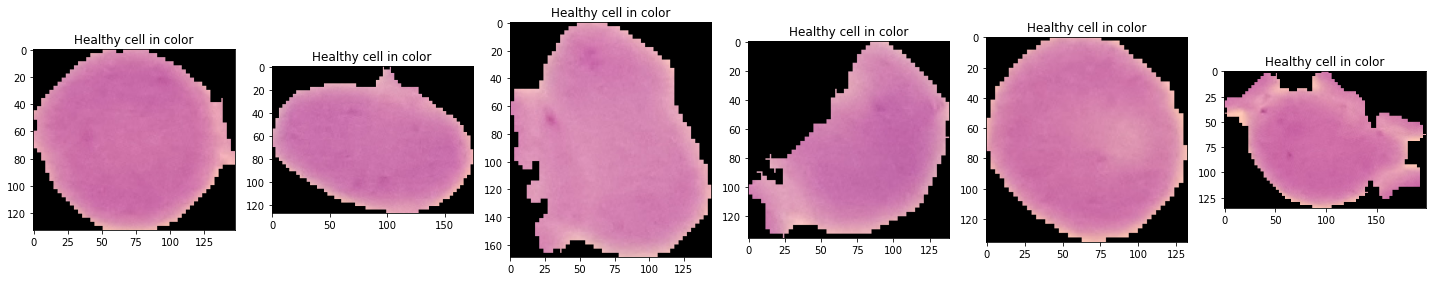

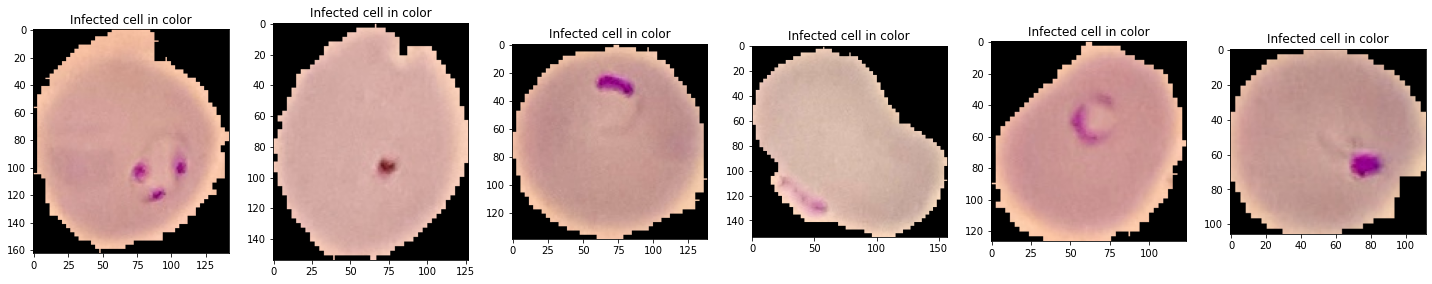

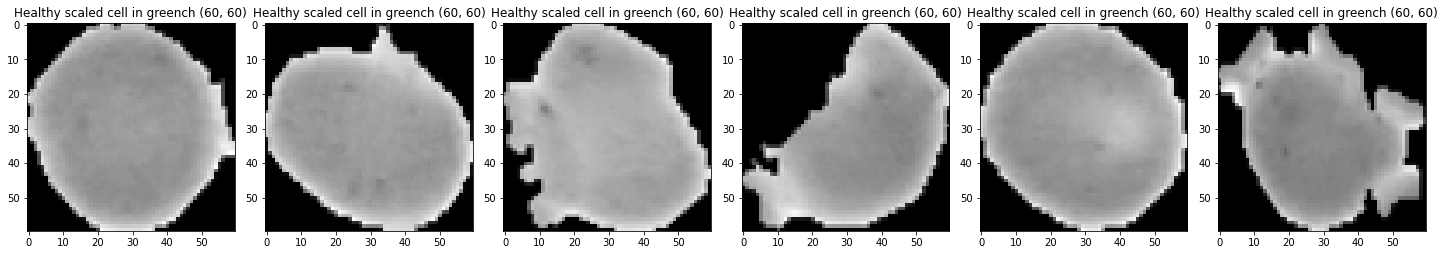

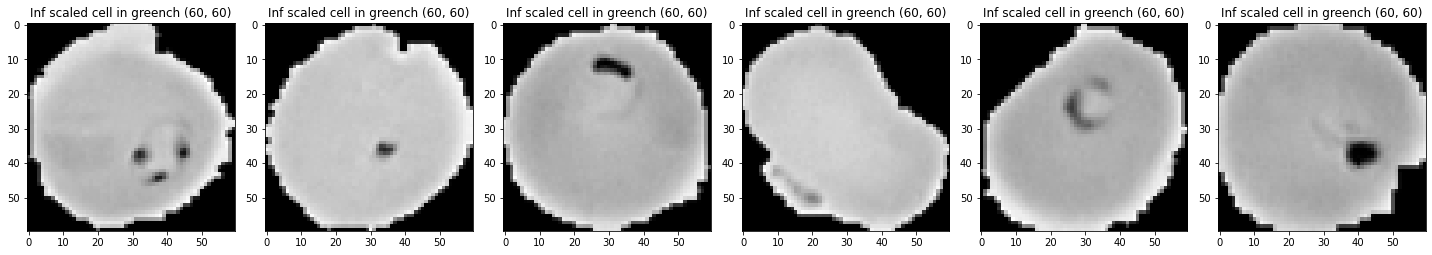

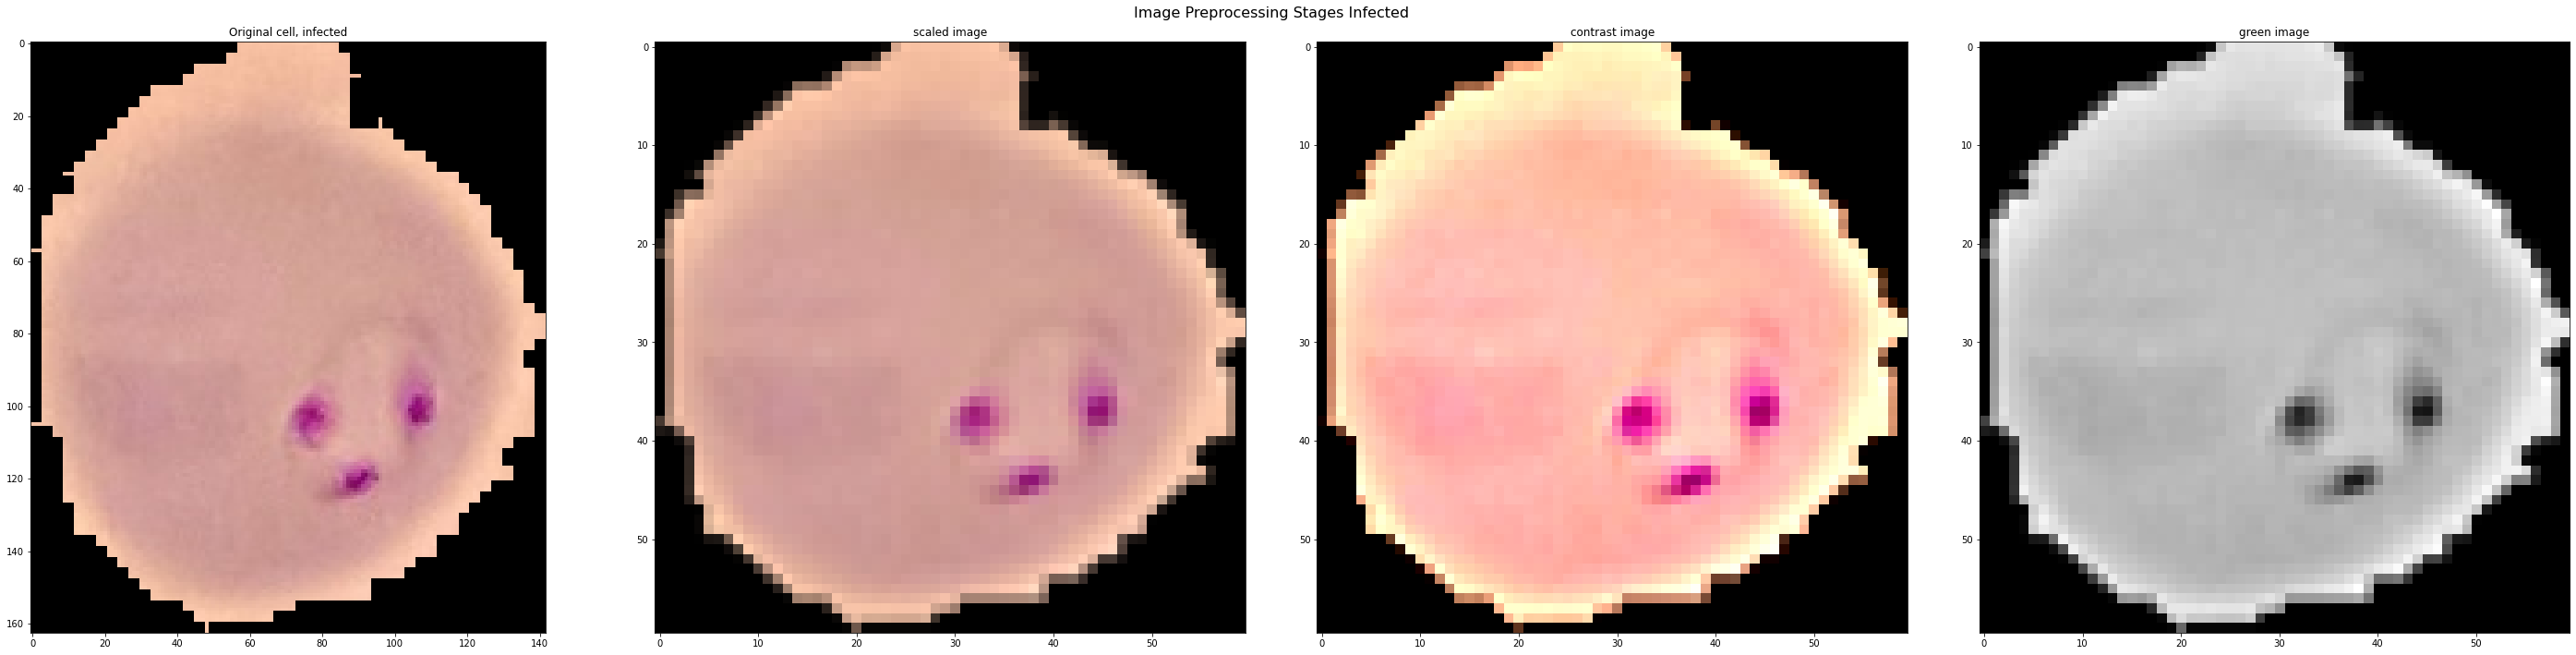

y, "Parasitized"= 1, "Uninfected"= 0 
y[0:40]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
length of (y)
8000


In [6]:
def display_individual_images(image_paths):
    ###################

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    fig.suptitle('Healthy sample cell Image and Histogram', fontsize=16)
    axes[0].imshow(images[0], cmap='gray')
    axes[0].title.set_text('Sample cell healthy')
    axes[1].hist(images[0])
    axes[1].title.set_text('histogram of healthy cell ')
    fig.tight_layout()
    plt.show()
    ####################

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    fig.suptitle('Infected sample cell Image and Histogram', fontsize=16)
    start = int(len(images) / 2)
    axes[0].imshow(images[start + 2], cmap='gray')
    axes[0].title.set_text('Sample cell infected')
    axes[1].hist(images[start + 2])
    axes[1].title.set_text('histogram of infected cell ')
    fig.tight_layout()
    plt.show()
    ####################
    # Image Analysis
    # % matplotlib inline
    pic = imageio.imread(image_paths[0])
    plt.figure(figsize=(5, 5))
    plt.title('Sample cell healthy')
    plt.imshow(pic)
    plt.show()

    print('Type of the image : Portable Network Graphics .png ')
    print('Shape of the image : {}'.format(pic.shape))
    print('Image Height {}'.format(pic.shape[0]))
    print('Image Width {}'.format(pic.shape[1]))
    print('Dimension of Image {}'.format(pic.ndim))

    print('Image pixel * 3 color channels  {}'.format(pic.size))
    print('Maximum RGB value in this image {}'.format(pic.max()))
    print('Minimum RGB value in this image {}'.format(pic.min()))

    start = int(len(images) / 2)
    pic = imageio.imread(image_paths[start + 3])
    plt.figure(figsize=(5, 5))
    plt.title('Sample infected cell')
    plt.imshow(pic)
    plt.show()

    # print('Type of the image : ', type(pic))
    print('Type of the image : Portable Network Graphics .png ')
    print('Shape of the image : {}'.format(pic.shape))
    print('Image Height {}'.format(pic.shape[0]))
    print('Image Width {}'.format(pic.shape[1]))
    print('Dimension of Image {}'.format(pic.ndim))

    print('Image pixel size * 3 color channels {}'.format(pic.size))
    print('Maximum RGB value in this image {}'.format(pic.max()))
    print('Minimum RGB value in this image {}'.format(pic.min()))


# 2. Visualization & 2. Datenrepraesentation
display_individual_images(image_paths)

display_sample_images_raw(image_paths, 6, True)
display_sample_images_raw(image_paths, 6, False)

display_sample_images(images, 6, True)
display_sample_images(images, 6, False)

display_image_preprocessing(image_paths, False)

print('y, "Parasitized"= 1, "Uninfected"= 0 ')
print('y[0:40]')
print(y[0:40])
print('length of (y)')
print(len(y))

### Prepare Data for Training and Testing

In [7]:
# Prepare Data for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=4, stratify=y)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


def reshape_x_for_model(np_data):
    print('Reshaping this: ' + str(np_data.shape))
    print(np_data.shape)
    nsamples, nx, ny = np_data.shape
    np_data = np_data.reshape((nsamples, nx * ny))
    # print(np_data.shape)
    # Noetig?
    # np_data = np_data.reshape(np_data.shape[0], -1)
    return np_data


X_train = reshape_x_for_model(X_train)
print('X_train.shape')
print(X_train.shape)
X_test = reshape_x_for_model(X_test)
print('X_test.shape')
print(X_test.shape)

print('len(X_train)')
print(len(X_train))
print('len(y_train)')
print(len(y_train))

# print(X_train)
print('y_train[0:40] <- y_train ist durchmischt: ')
print(y_train[0:40])

Reshaping this: (6400, 60, 60)
(6400, 60, 60)
X_train.shape
(6400, 3600)
Reshaping this: (1600, 60, 60)
(1600, 60, 60)
X_test.shape
(1600, 3600)
len(X_train)
6400
len(y_train)
6400
y_train[0:40] <- y_train ist durchmischt: 
[0 1 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 1 0
 1 0 1]


### 3. Training and Evaluation

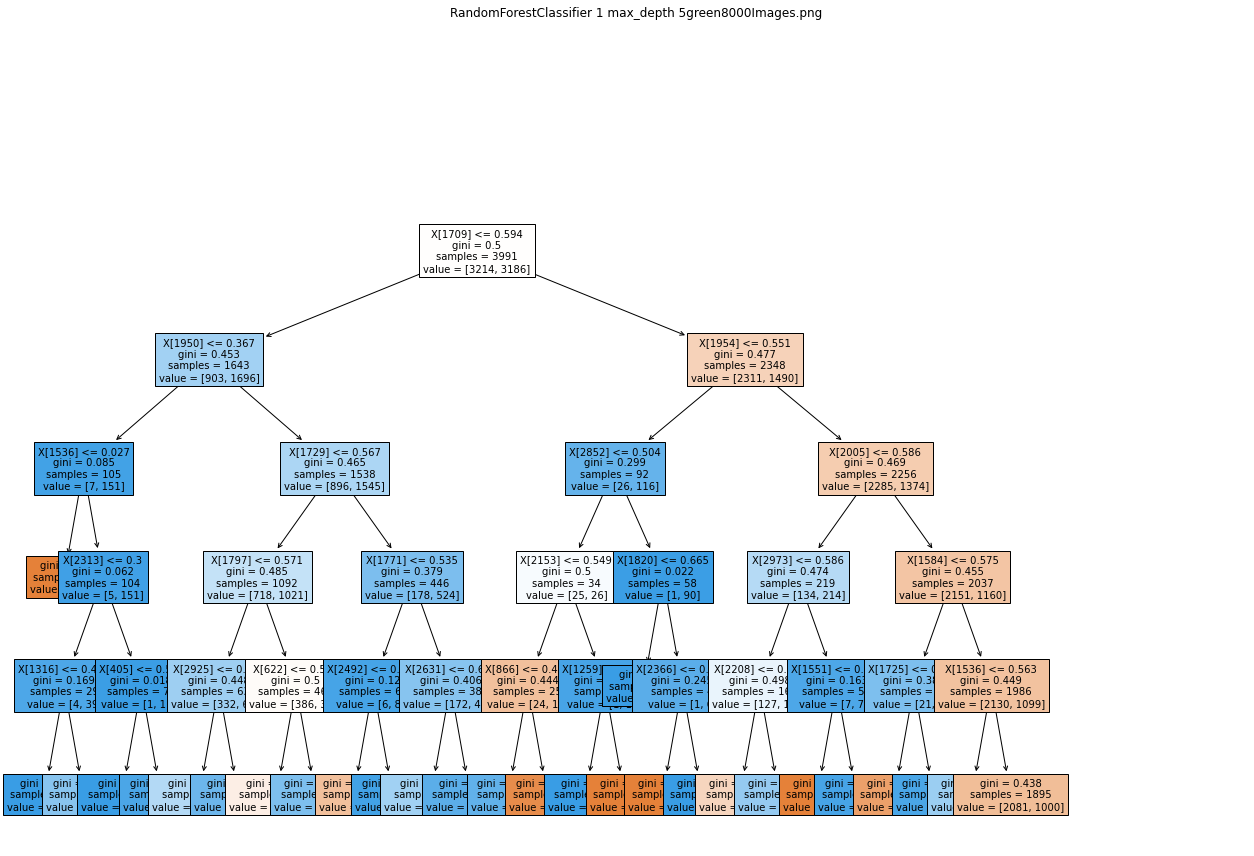

##########################################################################################
DecisionTreeClassifier(max_depth=5, max_features='auto', random_state=238902408)
RandomForestClassifier 1 Train accuracy:  0.71984375
RandomForestClassifier 1 Test accuracy:  0.6975
Precision: 0.6931540342298288
Recall: 0.70875
##########################################################################################
Running time: 18.13987636566162


In [8]:
##################################
# 3. Training
def run_random_forest1():
    model_name = 'RandomForestClassifier 1 max_depth 5'
    start_time = time.time()
    forest = RandomForestClassifier(
        n_estimators=1000,  # Anzahl der Bäume. Sinnvolle sind 100, 200, 500, maximal 1000
        max_depth=5,  # Tiefe der Bäume
        n_jobs=-1  # Anzahl der Prozessoren, -1 steht für alle vorhandenen
    )
    forest.fit(X_train, y_train)
    #################################
    # plot tree
    fig = plt.figure(figsize=(18, 12))  # set plot size
    tree.plot_tree(forest.estimators_[0], fontsize=10, filled=True)
    title_txt = str(model_name) + str(color_channel) + str(number_of_datapoints) + 'Images.png'
    plt.title(title_txt)
    plt.tight_layout()
    plt.show()
    fig.savefig(title_txt)
    print('##########################################################################################')
    print(forest[3])
    # TODO: Modell evaluieren
    y_pred_test = forest.predict(X_test)
    y_pred_train = forest.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print("RandomForestClassifier 1 Train accuracy: ", accuracy_train)
    print("RandomForestClassifier 1 Test accuracy: ", accuracy_test)
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:", metrics.precision_score(y_test, y_pred_test))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:", metrics.recall_score(y_test, y_pred_test))
    print('##########################################################################################')
    elapsed_time = time.time() - start_time
    print('Running time: ' + str(elapsed_time))
    classification_model_stats.append([model_name, accuracy_test, accuracy_train, color_channel, elapsed_time])


# RandomForest
# Modell trainieren
run_random_forest1()

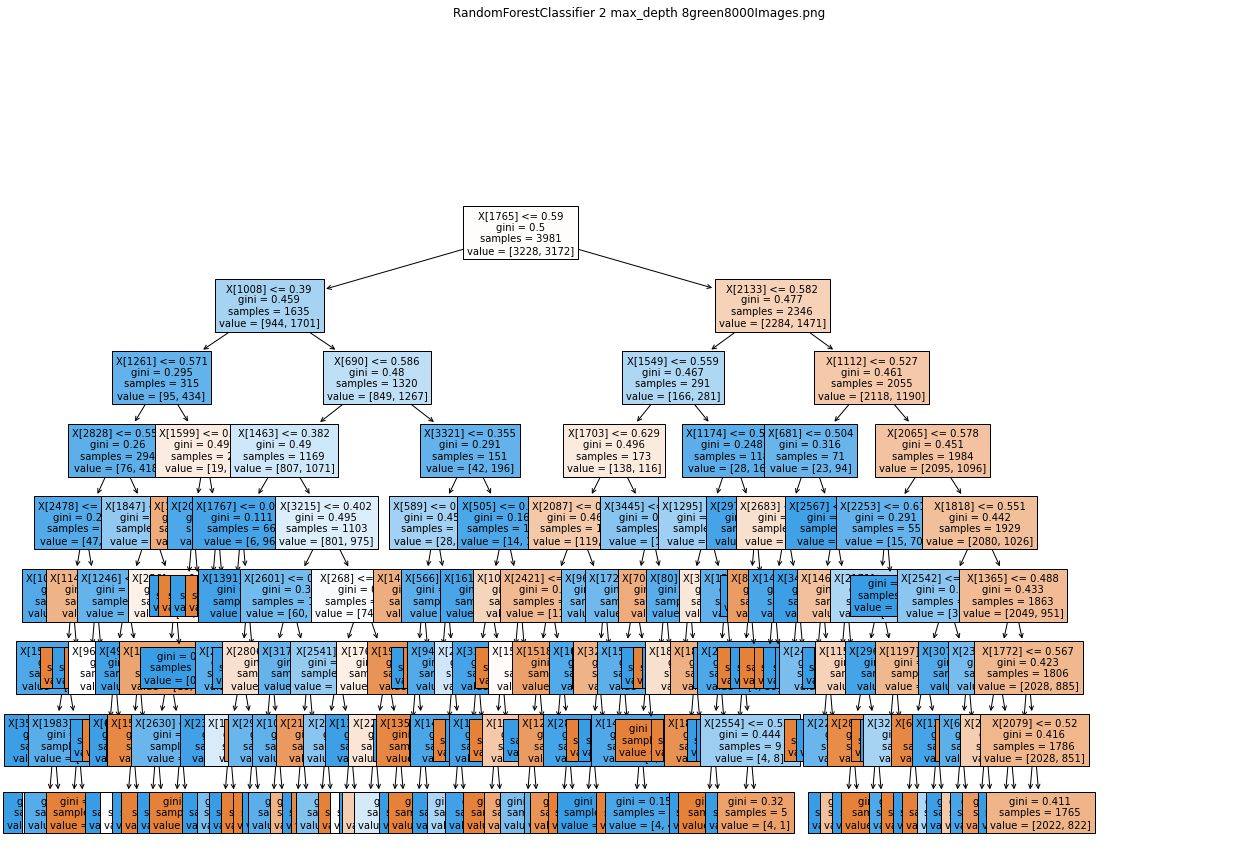

##########################################################################################
DecisionTreeClassifier(max_depth=8, max_features='auto', random_state=314784416)
Feature Importances: [0.00000000e+00 1.76164945e-06 3.41993312e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
RandomForestClassifier 2 Train accuracy:  0.8175
RandomForestClassifier 2 Test accuracy:  0.7275
Precision: 0.7363636363636363
Recall: 0.70875
##########################################################################################
Running time: 36.850942850112915


In [9]:
def run_random_forest2_deeper():
    model_name = 'RandomForestClassifier 2 max_depth 8'
    start_time = time.time()
    forest = RandomForestClassifier(
        n_estimators=1000,  # Anzahl der Bäume. Sinnvolle sind 100, 200, 500, maximal 1000
        max_depth=8,  # Tiefe der Bäume
        n_jobs=-1  # Anzahl der Prozessoren, -1 steht für alle vorhandenen
    )
    forest.fit(X_train, y_train)
    #################################
    # plot tree
    fig = plt.figure(figsize=(18, 12))  # set plot size
    tree.plot_tree(forest.estimators_[0], fontsize=10, filled=True)
    title_txt = str(model_name) + str(color_channel) + str(number_of_datapoints) + 'Images.png'
    plt.title(title_txt)
    plt.tight_layout()
    plt.show()
    fig.savefig(title_txt)
    print('##########################################################################################')
    print(forest[3])
    print("Feature Importances:", forest.feature_importances_)
    # TODO: Modell evaluieren
    y_pred_test = forest.predict(X_test)
    y_pred_train = forest.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print("RandomForestClassifier 2 Train accuracy: ", accuracy_train)
    print("RandomForestClassifier 2 Test accuracy: ", accuracy_test)
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:", metrics.precision_score(y_test, y_pred_test))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:", metrics.recall_score(y_test, y_pred_test))
    print('##########################################################################################')
    elapsed_time = time.time() - start_time
    print('Running time: ' + str(elapsed_time))
    classification_model_stats.append([model_name, accuracy_test, accuracy_train, color_channel, elapsed_time])


# RandomForest 2
#  Modell trainieren
run_random_forest2_deeper()

In [10]:
def accuracy_binary(y_pred_test, y_test):
    correctly_guessed = 0
    for i, elem in enumerate(y_test):
        if (elem == y_pred_test[i]):
            correctly_guessed += 1
    return correctly_guessed / len(y_test)


###########################
def run_svm1():
    model_name = 'Support Vector Machines Classifier & MinMaxScaler'
    start_time = time.time()
    svm_model = make_pipeline(
        # StandardScaler(),
        MinMaxScaler(),
        SVC(
            C=1000000,
            kernel="rbf",  # (R)adial (B)asis (F)unctions
            gamma='scale'
        )
    )

    svm_model.fit(X_train, y_train)
    # Evaluation
    y_pred_test_svm = svm_model.predict(X_test)

    accuracy_test = accuracy_binary(y_pred_test_svm, y_test)

    y_pred_train_svm = svm_model.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train_svm)
    print('##########################################################################################')
    print(svm_model[1].__repr__)
    print("Support Vector Machines Classification and MinMaxScaler Train accuracy: ", accuracy_train)
    print('Support Vector Machines Classification and MinMaxScaler Test accuracy: ', accuracy_test)
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:", metrics.precision_score(y_test, y_pred_test_svm))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:", metrics.recall_score(y_test, y_pred_test_svm))
    print('##########################################################################################')
    elapsed_time = time.time() - start_time
    print('Running time: ' + str(elapsed_time))
    classification_model_stats.append([model_name, accuracy_test, accuracy_train, color_channel, elapsed_time])


# Support Vector Machines Classification
run_svm1()

##########################################################################################
<bound method BaseEstimator.__repr__ of SVC(C=1000000)>
Support Vector Machines Classification and MinMaxScaler Train accuracy:  1.0
Support Vector Machines Classification and MinMaxScaler Test accuracy:  0.705
Precision: 0.7186666666666667
Recall: 0.67375
##########################################################################################
Running time: 1057.852076292038


In [11]:
def run_svm2_pca_minmaxscaler():
    model_name = 'Support Vector Machines Classifier 2 & PCA & MinMaxScaler'
    start_time = time.time()
    svm_pca_model = make_pipeline(
        # StandardScaler(),
        MinMaxScaler(),
        PCA(n_components=0.99),
        SVC(
            C=1000000,
            kernel="rbf",  # (R)adial (B)asis (F)unctions
            gamma='scale'
        )
    )

    svm_pca_model.fit(X_train, y_train)
    # Evaluation

    y_pred_test_svm_pca = svm_pca_model.predict(X_test)
    accuracy_test = accuracy_binary(y_pred_test_svm_pca, y_test)

    y_pred_train_svm_pca = svm_pca_model.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train_svm_pca)
    print('##########################################################################################')
    print(svm_pca_model[1].__repr__())
    print("Support Vector Machines Classification 2 and MinMaxScaler and PCA Train accuracy: ", accuracy_train)
    print('Support Vector Machines Classification 2 and MinMaxScaler and PCA Test accuracy: ', accuracy_test)
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:", metrics.precision_score(y_test, y_pred_test_svm_pca))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:", metrics.recall_score(y_test, y_pred_test_svm_pca))
    print('##########################################################################################')
    elapsed_time = time.time() - start_time
    print('Running time: ' + str(elapsed_time))
    classification_model_stats.append([model_name, accuracy_test, accuracy_train, color_channel, elapsed_time])


# Support Vector Machines Classification 2 and PCA
run_svm2_pca_minmaxscaler()

##########################################################################################
PCA(n_components=0.99)
Support Vector Machines Classification 2 and MinMaxScaler and PCA Train accuracy:  1.0
Support Vector Machines Classification 2 and MinMaxScaler and PCA Test accuracy:  0.709375
Precision: 0.717815344603381
Recall: 0.69
##########################################################################################
Running time: 121.76058912277222


In [12]:
def run_svm3_pca_standardscaler():
    model_name = 'Support Vector Machines Classifier 3 & PCA & StandardScaler'
    start_time = time.time()
    svm_pca_model3 = make_pipeline(
        StandardScaler(),  # y = (x – mean) / standard_deviation
        # MinMaxScaler(),
        PCA(n_components=0.99),
        SVC(
            C=1000000,
            kernel="rbf",  # (R)adial (B)asis (F)unctions
            gamma='scale'
        )
    )
    svm_pca_model3.fit(X_train, y_train)
    # Evaluation

    y_pred_test_svm_pca3 = svm_pca_model3.predict(X_test)
    accuracy_test = accuracy_binary(y_pred_test_svm_pca3, y_test)

    y_pred_train_svm_pca3 = svm_pca_model3.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train_svm_pca3)
    print('##########################################################################################')
    print(svm_pca_model3[1].__repr__())
    print("Support Vector Machines Classification 3 and PCA and StandardScaler Train accuracy: ", accuracy_train)
    print('Support Vector Machines Classification 3 and PCA and StandardScaler Test accuracy: ', accuracy_test)
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:", metrics.precision_score(y_test, y_pred_test_svm_pca3))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:", metrics.recall_score(y_test, y_pred_test_svm_pca3))
    print('##########################################################################################')
    elapsed_time = time.time() - start_time
    print('Running time: ' + str(elapsed_time))
    classification_model_stats.append([model_name, accuracy_test, accuracy_train, color_channel, elapsed_time])


# Support Vector Machines Classification 3 and PCA and StandardScaler
run_svm3_pca_standardscaler()

##########################################################################################
PCA(n_components=0.99)
Support Vector Machines Classification 3 and PCA and StandardScaler Train accuracy:  1.0
Support Vector Machines Classification 3 and PCA and StandardScaler Test accuracy:  0.729375
Precision: 0.7373868046571799
Recall: 0.7125
##########################################################################################
Running time: 117.32223582267761


In [13]:
#############################
def run_logistic_regression():
    model_name = 'Logistic Regression & StandardScaler'
    start_time = time.time()
    model_log_reg = make_pipeline(
        StandardScaler(),  # y = (x – mean) / standard_deviation
        # MinMaxScaler(),
        LogisticRegression(C=0.1, max_iter=200)
    )
    model_log_reg.fit(X_train, y_train)
    # Evaluation

    y_pred_test_log_reg = model_log_reg.predict(X_test)
    accuracy_test = accuracy_binary(y_pred_test_log_reg, y_test)

    y_pred_train_log_reg = model_log_reg.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train_log_reg)
    print('##########################################################################################')
    print(model_log_reg[1].__repr__())
    print(model_name + " Train accuracy: " + str(accuracy_train))
    print(model_name + " Test accuracy: " + str(accuracy_test))
    print('model_log_reg.score(X_test, y_test)')
    print(model_log_reg.score(X_test, y_test))
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:", metrics.precision_score(y_test, y_pred_test_log_reg))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:", metrics.recall_score(y_test, y_pred_test_log_reg))
    print('##########################################################################################')
    elapsed_time = time.time() - start_time
    print('Running time: ' + str(elapsed_time))
    classification_model_stats.append([model_name, accuracy_test, accuracy_train, color_channel, elapsed_time])


# Logistic Regression
run_logistic_regression()

C:\Users\Alfa\anaconda3\envs\MachineLeaningAlfa\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##########################################################################################
LogisticRegression(C=0.1, max_iter=200)
Logistic Regression & StandardScaler Train accuracy: 0.85578125
Logistic Regression & StandardScaler Test accuracy: 0.583125
model_log_reg.score(X_test, y_test)
0.583125
Precision: 0.5853658536585366
Recall: 0.57
##########################################################################################
Running time: 6.0775392055511475


In [14]:
#####################################
def run_stochastic_gradient_descent():
    model_name = 'Stochastic Gradient Descent & StandardScaler'
    start_time = time.time()
    model_sgd = make_pipeline(
        StandardScaler(),  # y = (x – mean) / standard_deviation
        # MinMaxScaler(),
        SGDClassifier(max_iter=1000, tol=1e-3),
    )
    model_sgd.fit(X_train, y_train)
    # Evaluation

    y_pred_test_sgd = model_sgd.predict(X_test)
    accuracy_test = accuracy_binary(y_pred_test_sgd, y_test)

    y_pred_train_sgd = model_sgd.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train_sgd)
    print('##########################################################################################')
    print(model_sgd[1].__repr__())
    print(model_name + " Train accuracy: " + str(accuracy_train))
    print(model_name + " Test accuracy: " + str(accuracy_test))
    print('model_sgd.score(X_test, y_test)')
    print(model_sgd.score(X_test, y_test))
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:", metrics.precision_score(y_test, y_pred_test_sgd))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:", metrics.recall_score(y_test, y_pred_test_sgd))
    print('##########################################################################################')
    elapsed_time = time.time() - start_time
    print('Running time: ' + str(elapsed_time))
    classification_model_stats.append([model_name, accuracy_test, accuracy_train, color_channel, elapsed_time])


# Stochastic Gradient Descent
run_stochastic_gradient_descent()

##########################################################################################
SGDClassifier()
Stochastic Gradient Descent & StandardScaler Train accuracy: 0.82046875
Stochastic Gradient Descent & StandardScaler Test accuracy: 0.54875
model_sgd.score(X_test, y_test)
0.54875
Precision: 0.549492385786802
Recall: 0.54125
##########################################################################################
Running time: 6.421323776245117



# Neural Networks


In [15]:
#############################
# Neural Networks
#############################
def run_mlp_classifier():
    """Multi-layer Perceptron classifier """
    model_name = 'NN Multi-layer Perceptron Classifier & StandardScaler'
    start_time = time.time()
    model_mlp_classifier = make_pipeline(
        StandardScaler(),  # y = (x – mean) / standard_deviation
        # MinMaxScaler(),
        MLPClassifier(
            # hidden_layer_sizes=(1024, 512, 256, 128, 64), # Causes Overfitting, accuracy test   0.710
            # hidden_layer_sizes=(512, 256, 128, 64),       # , accuracy test  0.725
            # hidden_layer_sizes=(512, 256, 128, 64, 32),   # Underfitting, accuracy test 0.690
            # hidden_layer_sizes=(256, 128, 64),  # optimum , accuracy test  0.730 at 1000 images
            hidden_layer_sizes=(256, 128, 64),  # optimum , accuracy test  0.730 at 1000 images
            activation="relu",
            solver="adam",
            alpha=0.001,
            batch_size=64,
            learning_rate_init=0.001,
            verbose=10),
    )
    model_mlp_classifier.fit(X_train, y_train)
    # Evaluation

    y_pred_test_mlp = model_mlp_classifier.predict(X_test)
    accuracy_test = accuracy_binary(y_pred_test_mlp, y_test)

    y_pred_train_mlp = model_mlp_classifier.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train_mlp)
    print('##########################################################################################')
    print('Multi-layer Perceptron Classifier:')
    print(model_mlp_classifier[1].__repr__())
    print(model_name + " Train accuracy: " + str(accuracy_train))
    print(model_name + " Test accuracy: " + str(accuracy_test))
    # print('Multi-layer Perceptron classifier and StandardScaler accuracy for Test Data:')
    # print(accuracy_test)
    print('Multi-layer Perceptron classifier Test accuracy by .score(X_test, y_test)')
    print(model_mlp_classifier.score(X_test, y_test))
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Multi-layer Perceptron classifier Precision:", metrics.precision_score(y_test, y_pred_test_mlp))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Multi-layer Perceptron classifier Recall:", metrics.recall_score(y_test, y_pred_test_mlp))
    print('##########################################################################################')
    elapsed_time = time.time() - start_time
    print('Running time: ' + str(elapsed_time))
    classification_model_stats.append([model_name, accuracy_test, accuracy_train, color_channel, elapsed_time])


# Multi-layer Perceptron classifier
run_mlp_classifier()

Iteration 1, loss = 0.67937906
Iteration 2, loss = 0.57117681
Iteration 3, loss = 0.50163485
Iteration 4, loss = 0.43201194
Iteration 5, loss = 0.36798696
Iteration 6, loss = 0.30861535
Iteration 7, loss = 0.27252022
Iteration 8, loss = 0.19575887
Iteration 9, loss = 0.17714975
Iteration 10, loss = 0.19542569
Iteration 11, loss = 0.13405361
Iteration 12, loss = 0.11122939
Iteration 13, loss = 0.11652023
Iteration 14, loss = 0.14046142
Iteration 15, loss = 0.11586738
Iteration 16, loss = 0.07627643
Iteration 17, loss = 0.10351050
Iteration 18, loss = 0.14318639
Iteration 19, loss = 0.09523934
Iteration 20, loss = 0.09667005
Iteration 21, loss = 0.09819009
Iteration 22, loss = 0.05747694
Iteration 23, loss = 0.03538614
Iteration 24, loss = 0.03609624
Iteration 25, loss = 0.02942496
Iteration 26, loss = 0.03822831
Iteration 27, loss = 0.04185885
Iteration 28, loss = 0.13752127
Iteration 29, loss = 0.12957797
Iteration 30, loss = 0.08865281
Iteration 31, loss = 0.06399123
Iteration 32, los

# 4. Evaluation
# Collected Data about Classification Models displayed as Table and Graph

                                                    model_name  accuracy_test  accuracy_train color_channel  running_time
0                         RandomForestClassifier 1 max_depth 5       0.697500        0.719844         green     18.139876
1                         RandomForestClassifier 2 max_depth 8       0.727500        0.817500         green     36.850943
2            Support Vector Machines Classifier & MinMaxScaler       0.705000        1.000000         green   1057.852076
3    Support Vector Machines Classifier 2 & PCA & MinMaxScaler       0.709375        1.000000         green    121.760589
4  Support Vector Machines Classifier 3 & PCA & StandardScaler       0.729375        1.000000         green    117.322236
5                         Logistic Regression & StandardScaler       0.583125        0.855781         green      6.077539
6                 Stochastic Gradient Descent & StandardScaler       0.548750        0.820469         green      6.421324
7        NN Multi-layer 

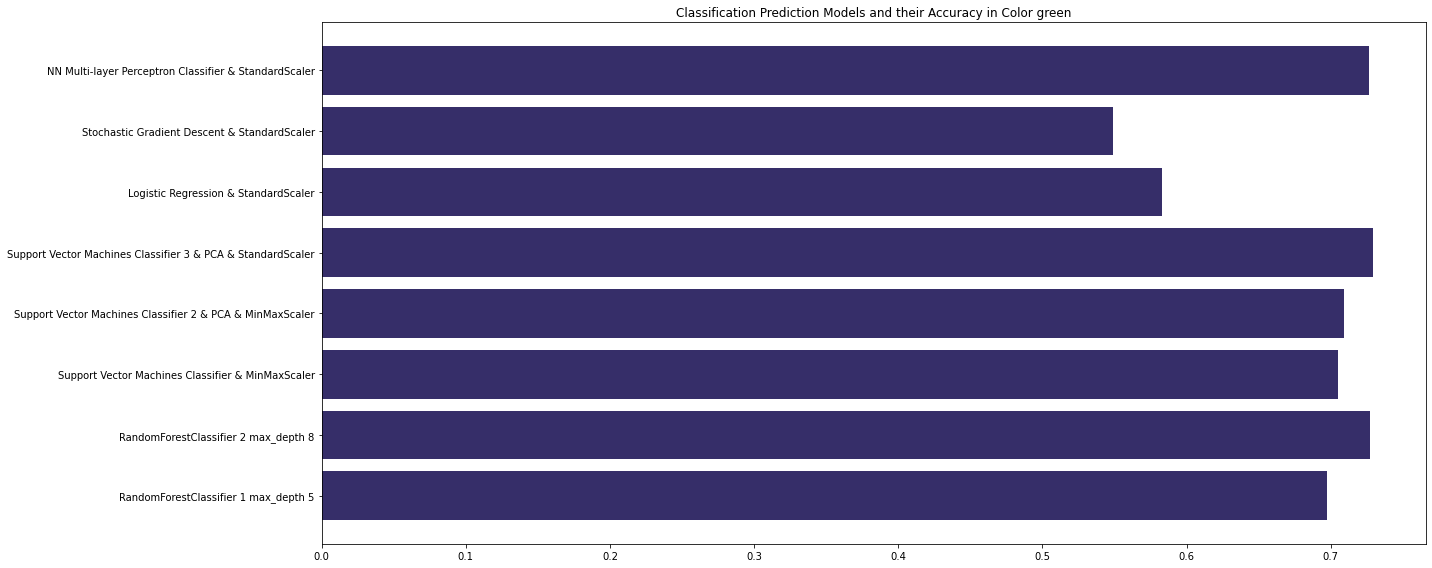

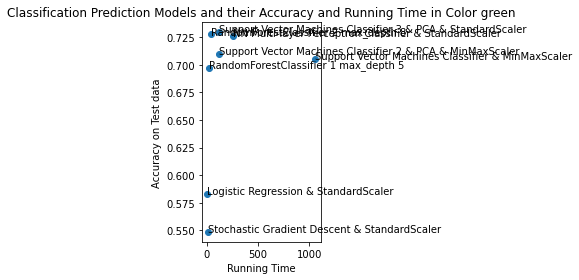

,model_name,accuracy_test,accuracy_train,color_channel,running_time
0,RandomForestClassifier 1 max_depth 5,0.697500,0.719844,green,18.139876
1,RandomForestClassifier 2 max_depth 8,0.727500,0.817500,green,36.850943
2,Support Vector Machines Classifier & MinMaxScaler,0.705000,1.000000,green,1057.852076
3,Support Vector Machines Classifier 2 & PCA & M...,0.709375,1.000000,green,121.760589
4,Support Vector Machines Classifier 3 & PCA & S...,0.729375,1.000000,green,117.322236
5,Logistic Regression & StandardScaler,0.583125,0.855781,green,6.077539
6,Stochastic Gradient Descent & StandardScaler,0.548750,0.820469,green,6.421324
7,NN Multi-layer Perceptron Classifier & Standar...,0.726250,0.984219,green,254.775082


In [16]:
#############################################################################
# 4. Evaluation
# Collected Data about Classification Models displayed as Table and Graph
classification_model_stats_pd = pd.DataFrame(classification_model_stats,
                                             columns=['model_name', 'accuracy_test', 'accuracy_train', 'color_channel',
                                                      'running_time'])
print(classification_model_stats_pd.to_string())


def visualize_model_statistics(classification_model_stats_pd):
    fig = plt.figure(figsize=(20, 8))
    plt.title('Classification Prediction Models and their Accuracy in Color ' + color_channel)
    x = classification_model_stats_pd['model_name']
    y = classification_model_stats_pd['accuracy_test']
    plt.barh(x, y, color="#362e69")
    plt.tight_layout()
    plt.show()
    title_txt = 'ModelsStat' + str(color_channel) + str(number_of_datapoints) + 'Images.png'
    fig.savefig(title_txt)

    fig2, ax = plt.subplots()
    plt.title('Classification Prediction Models and their Accuracy and Running Time in Color ' + color_channel)
    x = classification_model_stats_pd['running_time']
    y = classification_model_stats_pd['accuracy_test']
    n = classification_model_stats_pd['model_name']
    plt.xlabel("Running Time")
    plt.ylabel("Accuracy on Test data")
    ax.scatter(x, y)
    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i], y[i]))
    plt.tight_layout()
    plt.show()
    title_txt = 'ModelsScatterXY' + str(color_channel) + str(number_of_datapoints) + 'Images.png'
    fig2.savefig(title_txt)


visualize_model_statistics(classification_model_stats_pd)
classification_model_stats_pd

# Individual Color Channels

### GRAY

In [ ]:
# Scaling
image_width = 60
image_height = 60

color_channel = 'gray'
# color_channel = 'red'
# color_channel = 'green'
# color_channel = 'blue'

# filepath_root = "./data/cell_images_mini"  # 20 *2 Images
filepath_root = "./data/cell_images_midi"  # 500 * 2 Images
# filepath_root = "./data/cell_images_venti"  # 4000 * 2  Images
# filepath_root = "./data/cell_images"  #   13780 * 2  Images

### RED

In [ ]:
# Scaling
image_width = 60
image_height = 60

# color_channel = 'gray'
color_channel = 'red'
# color_channel = 'green'
# color_channel = 'blue'

# filepath_root = "./data/cell_images_mini"  # 20 *2 Images
filepath_root = "./data/cell_images_midi"  # 500 * 2 Images
# filepath_root = "./data/cell_images_venti"  # 4000 * 2  Images
# filepath_root = "./data/cell_images"  #   13780 * 2  Images

### GREEN

In [ ]:
# Scaling
image_width = 60
image_height = 60

# color_channel = 'gray'
# color_channel = 'red'
color_channel = 'green'
# color_channel = 'blue'

# filepath_root = "./data/cell_images_mini"  # 20 *2 Images
filepath_root = "./data/cell_images_midi"  # 500 * 2 Images
# filepath_root = "./data/cell_images_venti"  # 4000 * 2  Images
# filepath_root = "./data/cell_images"  #   13780 * 2  Images

### BLUE

In [ ]:
# Scaling
image_width = 60
image_height = 60

# color_channel = 'gray'
# color_channel = 'red'
# color_channel = 'green'
color_channel = 'blue'

# filepath_root = "./data/cell_images_mini"  # 20 *2 Images
filepath_root = "./data/cell_images_midi"  # 500 * 2 Images
# filepath_root = "./data/cell_images_venti"  # 4000 * 2  Images
# filepath_root = "./data/cell_images"  #   13780 * 2  Images